Merge data from all data files

In [79]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [80]:
df= pd.read_csv('Bib_1.csv')
df=df.drop_duplicates()
df1 = df[['ChildID','PregnancyID', 'MotherID', 'admincdobagemy','eth0eth9gp', 'eclregpart',
          'bkfmumbkwt','mms0height','mms0mbkbmi', 'prnbp3rdtriw',
          'bkfdiabete', 'prnprexconeclampsia','prnprexconhighbp','prnprfhistecl',
          'gttfastglu', 'gttpostglu','ecllgaukwho', 'eclsgaukwho','eclgestwks']]


In [81]:
df= pd.read_csv('Bib_2.csv')
df=df.drop_duplicates()
df2 = df[['ChildID','PregnancyID', 'MotherID', 'prnbpgdm','prnbpgdmt_diet',
               'prnbpgdmt_insulin','prnbpgdmt_lifestyle','prnbpgdmt_metformin','prnbpgdmt_none',
               'prnbpgdmt_notdoc','prnbpgestht','prnbppreeclampsia']]

In [82]:
df= pd.read_csv('Bib_5.csv')
df=df.drop_duplicates()
df3 = df[['ChildID','PregnancyID', 'MotherID','prnprfhistdiab']]

In [83]:
# Previous GDM diagnosis, Previous macrosomic infant
df4 = pd.read_csv('previous_GDM_withNaN.csv')
df5 = pd.read_csv('previous_macrosomia.csv')

# abdomcirc and foetal weight measurment features
df6 = pd.read_csv('abdomCircStatistics.csv')
df7 = pd.read_csv('foetalWeightStatistics.csv')


In [84]:
from functools import reduce
df = reduce(lambda x,y: pd.merge(x,y, on=('ChildID','PregnancyID', 'MotherID'), how='outer'), 
       [df1, df2, df3, df4, df5, df6, df7])

In [85]:
df=df.drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13858 entries, 0 to 14476
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ChildID              13858 non-null  int64  
 1   PregnancyID          13858 non-null  object 
 2   MotherID             13858 non-null  int64  
 3   admincdobagemy       13858 non-null  int64  
 4   eth0eth9gp           11450 non-null  object 
 5   eclregpart           13029 non-null  float64
 6   bkfmumbkwt           13053 non-null  float64
 7   mms0height           11221 non-null  float64
 8   mms0mbkbmi           10625 non-null  float64
 9   prnbp3rdtriw         6236 non-null   float64
 10  bkfdiabete           12934 non-null  object 
 11  prnprexconeclampsia  1933 non-null   object 
 12  prnprexconhighbp     2045 non-null   object 
 13  prnprfhistecl        11059 non-null  object 
 14  gttfastglu           12401 non-null  float64
 15  gttpostglu           12383 non-null 

# Drop twin and triplet data (children with same PregnancyID)

In [86]:
# remove twin and triplet data
df = df.drop_duplicates(subset='PregnancyID', keep=False)
df.shape

# 363 children dropped (BiB contains 354 twins and 9 triplets)

(13495, 41)

# Drop rows with missing values for lga

In [87]:
df['ecllgaukwho'].isna().sum()

301

In [88]:
# drop rows with missing value for target variable lga
df = df.dropna(subset=['ecllgaukwho'])
print(df.shape)

(13194, 41)


# Drop premature infants born <34 weeks

In [89]:
# see how many GDM women gave birth to premature babies <34 weeks
len(df[df['eclgestwks']<34])

217

In [90]:
# keep women whose infants were born after 33 weeks
df = df[df['eclgestwks']>33]
df.shape

(12977, 41)

In [91]:
df['eth0eth9gp'].value_counts(normalize =True)*100

Pakistani                      45.404446
White British                  39.519895
Indian                          3.820288
Other                           2.708761
White Other                     2.662059
Bangladeshi                     2.335139
Black                           2.008220
Mixed-White and Black           0.962077
Mixed-White and South Asian     0.579115
Name: eth0eth9gp, dtype: float64

# Replace missing values in Sparse features with 'No'

In [92]:
df[["prnbpgdmt_diet", "prnbpgdmt_insulin", "prnbpgdmt_lifestyle",
    "prnbpgdmt_metformin","prnbpgdmt_none", "prnbpgdmt_notdoc"]]= df[["prnbpgdmt_diet", "prnbpgdmt_insulin", "prnbpgdmt_lifestyle", "prnbpgdmt_metformin",
  "prnbpgdmt_none", "prnbpgdmt_notdoc"]].replace(np.NaN, 'No')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12977 entries, 0 to 14380
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ChildID              12977 non-null  int64  
 1   PregnancyID          12977 non-null  object 
 2   MotherID             12977 non-null  int64  
 3   admincdobagemy       12977 non-null  int64  
 4   eth0eth9gp           10706 non-null  object 
 5   eclregpart           12507 non-null  float64
 6   bkfmumbkwt           12541 non-null  float64
 7   mms0height           10494 non-null  float64
 8   mms0mbkbmi           10199 non-null  float64
 9   prnbp3rdtriw         6179 non-null   float64
 10  bkfdiabete           12422 non-null  object 
 11  prnprexconeclampsia  1834 non-null   object 
 12  prnprexconhighbp     1940 non-null   object 
 13  prnprfhistecl        10594 non-null  object 
 14  gttfastglu           11622 non-null  float64
 15  gttpostglu           11604 non-null 

In [94]:
print(df['prnprexconeclampsia'].unique())

['Not documented' 'No' nan 'Yes']


# Drop Features with high percentage of missing values

In [95]:
# calculate percentage of missing data
missing_values = (df.isna().mean().round(4) * 100)

In [96]:
missing_values

ChildID                 0.00
PregnancyID             0.00
MotherID                0.00
admincdobagemy          0.00
eth0eth9gp             17.50
eclregpart              3.62
bkfmumbkwt              3.36
mms0height             19.13
mms0mbkbmi             21.41
prnbp3rdtriw           52.38
bkfdiabete              4.28
prnprexconeclampsia    85.87
prnprexconhighbp       85.05
prnprfhistecl          18.36
gttfastglu             10.44
gttpostglu             10.58
ecllgaukwho             0.00
eclsgaukwho             0.00
eclgestwks              0.00
prnbpgdm               18.38
prnbpgdmt_diet          0.00
prnbpgdmt_insulin       0.00
prnbpgdmt_lifestyle     0.00
prnbpgdmt_metformin     0.00
prnbpgdmt_none          0.00
prnbpgdmt_notdoc        0.00
prnbpgestht            18.46
prnbppreeclampsia      18.46
prnprfhistdiab         18.36
pregdm                 64.14
premacrosomia          55.77
meanAbdomCirc          52.77
maxAbdomCirc           52.77
minAbdomCirc           52.77
varAbdomCirc  

In [97]:
# drop features with % missing values > 65% (was going to go qith 50% but want to keep ma)

dropList = []
for i in range(len(missing_values)):
    if (missing_values[i]>65 ):
        dropList.append(i)

print(dropList)


# Dropped prnprexconeclampsia (Previous eclampsia), prnprexconhighbp (Pre-existing high blood pressure) CHECK THESE ARENT SPARSELY CODED

[11, 12]


In [98]:
df = df.drop(df.columns[dropList], axis=1)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12977 entries, 0 to 14380
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ChildID              12977 non-null  int64  
 1   PregnancyID          12977 non-null  object 
 2   MotherID             12977 non-null  int64  
 3   admincdobagemy       12977 non-null  int64  
 4   eth0eth9gp           10706 non-null  object 
 5   eclregpart           12507 non-null  float64
 6   bkfmumbkwt           12541 non-null  float64
 7   mms0height           10494 non-null  float64
 8   mms0mbkbmi           10199 non-null  float64
 9   prnbp3rdtriw         6179 non-null   float64
 10  bkfdiabete           12422 non-null  object 
 11  prnprfhistecl        10594 non-null  object 
 12  gttfastglu           11622 non-null  float64
 13  gttpostglu           11604 non-null  float64
 14  ecllgaukwho          12977 non-null  object 
 15  eclsgaukwho          12977 non-null 

# Rename columns in New Dataset

In [100]:
df.columns

Index(['ChildID', 'PregnancyID', 'MotherID', 'admincdobagemy', 'eth0eth9gp',
       'eclregpart', 'bkfmumbkwt', 'mms0height', 'mms0mbkbmi', 'prnbp3rdtriw',
       'bkfdiabete', 'prnprfhistecl', 'gttfastglu', 'gttpostglu',
       'ecllgaukwho', 'eclsgaukwho', 'eclgestwks', 'prnbpgdm',
       'prnbpgdmt_diet', 'prnbpgdmt_insulin', 'prnbpgdmt_lifestyle',
       'prnbpgdmt_metformin', 'prnbpgdmt_none', 'prnbpgdmt_notdoc',
       'prnbpgestht', 'prnbppreeclampsia', 'prnprfhistdiab', 'pregdm',
       'premacrosomia', 'meanAbdomCirc', 'maxAbdomCirc', 'minAbdomCirc',
       'varAbdomCirc', 'rangeAbdomCirc', 'meanFoetalWeight', 'maxFoetalWeight',
       'minFoetalWeight', 'varFoetalWeight', 'rangeFoetalWeight'],
      dtype='object')

In [101]:
df=df.rename(columns={'admincdobagemy':'maternalAge','eth0eth9gp':'ethnicity', 'eclregpart':'parity',
                      'bkfmumbkwt':'bookingWeight', 'mms0height':'maternalHeight','mms0mbkbmi':'bookingBMI',
                      'prnbp3rdtriw':'thirdTrimesterWeight',
                      'bkfdiabete':'maternalDiabetes', 'prnprfhistecl':'fhEclampsia',
                      'gttfastglu':'fastingGlucose','gttpostglu': 'postGlucose', 'ecllgaukwho':'lga',
                      'prnbpgdm':'gdm', 'prnbpgdmt_diet':'gdmDiet','prnbpgdmt_insulin':'gdmInsulin' ,
                      'prnbpgdmt_lifestyle':'gdmLifestyle' , 'prnbpgdmt_metformin':'gdmMetformin',
                      'prnbpgdmt_none':'gdmNoTreatment', 'prnbpgdmt_notdoc':'gdmNotDoc',
                      'prnbpgestht':'gestHypertension','prnbppreeclampsia':'gestEclampsia', 'prnprfhistdiab':'fhDiabetes'})

# Rearrange columns 
such that categorical features are first followed by numerical features

In [102]:
df= df[['ChildID', 'PregnancyID', 'MotherID','ethnicity','maternalDiabetes','fhEclampsia',
       'gdm','gdmDiet','gdmInsulin','gdmLifestyle','gdmMetformin','gdmNoTreatment','gdmNotDoc',
        'gestHypertension','gestEclampsia','fhDiabetes','pregdm','premacrosomia',
        'maternalAge','parity','bookingWeight', 'bookingBMI','thirdTrimesterWeight', 'maternalHeight', 
        'fastingGlucose', 'postGlucose',
        'meanAbdomCirc','maxAbdomCirc', 'minAbdomCirc', 'varAbdomCirc', 'rangeAbdomCirc',
        'meanFoetalWeight', 'maxFoetalWeight', 'minFoetalWeight','varFoetalWeight', 'rangeFoetalWeight','lga']]

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12977 entries, 0 to 14380
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ChildID               12977 non-null  int64  
 1   PregnancyID           12977 non-null  object 
 2   MotherID              12977 non-null  int64  
 3   ethnicity             10706 non-null  object 
 4   maternalDiabetes      12422 non-null  object 
 5   fhEclampsia           10594 non-null  object 
 6   gdm                   10592 non-null  object 
 7   gdmDiet               12977 non-null  object 
 8   gdmInsulin            12977 non-null  object 
 9   gdmLifestyle          12977 non-null  object 
 10  gdmMetformin          12977 non-null  object 
 11  gdmNoTreatment        12977 non-null  object 
 12  gdmNotDoc             12977 non-null  object 
 13  gestHypertension      10582 non-null  object 
 14  gestEclampsia         10582 non-null  object 
 15  fhDiabetes         

In [104]:
# what percentage of children are LGA
df['lga'].value_counts(normalize =True)*100
#df['lga'].value_counts()

No     92.771827
Yes     7.228173
Name: lga, dtype: float64

# Group Ethnicity Data

In [105]:
# first see % missing values in ethnicity
df['ethnicity'].isna().mean().round(4) * 100

17.5

In [106]:
# add dropna=False for NaNs to be tallied 
df['ethnicity'].value_counts(normalize=True, dropna=False)*100

Pakistani                      37.458581
White British                  32.603838
NaN                            17.500193
Indian                          3.151730
Other                           2.234723
White Other                     2.196193
Bangladeshi                     1.926485
Black                           1.656777
Mixed-White and Black           0.793712
Mixed-White and South Asian     0.477768
Name: ethnicity, dtype: float64

In [107]:
col         = 'ethnicity'
conditions  = [ (df[col].isin(['White British', 'White Other'])),
               (df[col].isin(['Indian', 'Pakistani', 'Bangladeshi'])),
               (df[col].isin(['Other', 'Black', 'Mixed-White and Black', 'Mixed-White and South Asian']))]
choices     = ['White', 'South Asian', 'Other']
    
df['ethnicity'] = np.select(conditions, choices, default=np.nan)
#df5.to_csv('ethnicity.csv', index=False)

In [108]:
df['ethnicity'].value_counts(normalize=True)*100

# nan column is missing value column

South Asian    42.536796
White          34.800031
nan            17.500193
Other           5.162981
Name: ethnicity, dtype: float64

In [109]:
df['lga'].value_counts(normalize=True, dropna=False)*100


No     92.771827
Yes     7.228173
Name: lga, dtype: float64

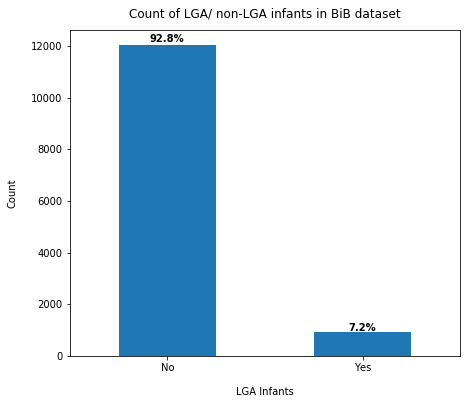

In [117]:
#import seaborn as sns
#sns.set(font_scale=1.4)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

total_infants = df['lga'].size


# compute percentage of LGA/ non-LGA infants
df1=pd.DataFrame()
df1['Percentage'] = df['lga'].value_counts(normalize=True, dropna=False)*100
df1['Percentage'][1]


# plot bar chart of LGA/ non-LGA infants
ax = df['lga'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("LGA Infants", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of LGA/ non-LGA infants in BiB dataset", y=1.02);


# print percentage of LGA/ non-LGA infants over each bar
i = 0
for p in ax.patches:

    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str("{:.1f}".format(df1.Percentage[i]))+'%',
             ha='center',
             weight='bold')
    i+=1
fig.savefig('figures/bib_LGA_nonLGA_barchart.svg', format='svg', dpi=1200)
plt.show()

# Make feature and target dataframes

In [69]:
# import full dataset before preprocessing

df1 = df.drop(columns=['ChildID', 'PregnancyID','MotherID'])
df1.to_csv('BibFullDataset.csv', index=False)
#df1.info()

In [70]:
# make feature matrix and target matrix
X = df.drop(columns=['lga','ChildID', 'PregnancyID','MotherID'])
y = df['lga']

X.to_csv('BibFeaturesMatrix.csv', index=False)
y.to_csv("BibDependentVariableLGA.csv", index=False)


In [71]:
# encode target variable 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
#print(y)

In [72]:
# define categorical and numeric transformers
numeric_transformer = Pipeline(steps=[
    ('knnImputer', KNNImputer(n_neighbors=2, weights="uniform")),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#  dispatch object columns to the categorical_transformer and remaining columns to numerical_transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, selector(dtype_include=['object'])),
    ('num', numeric_transformer, selector(dtype_include=['float64','int64']))
])

X = pd.DataFrame(preprocessor.fit_transform(X))

# Rename Feature columns after Preprocessing and OHE

In [73]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        print('\n\ntransformer: ', transformer_in_columns[0])
        
        raw_col_name = list(transformer_in_columns[2])
        
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
          if isinstance(transformer, OneHotEncoder):
            names = list(transformer.get_feature_names_out(raw_col_name))
            
          elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]

            names = raw_col_name + missing_indicators
            
          else:
            names = list(transformer.get_feature_names_out())
          
        except AttributeError as error:
          names = raw_col_name
        
        print(names)    
        
        col_name.extend(names)
            
    return col_name

In [74]:
newColNames=get_column_names_from_ColumnTransformer(preprocessor)



transformer:  cat
['ethnicity_Other', 'ethnicity_South Asian', 'ethnicity_White', 'ethnicity_nan', 'maternalDiabetes_No', 'maternalDiabetes_Yes', 'maternalDiabetes_missing', 'fhEclampsia_No', 'fhEclampsia_Not documented', 'fhEclampsia_Yes', 'fhEclampsia_missing', 'gdm_No', 'gdm_Yes', 'gdm_missing', 'gdmDiet_No', 'gdmDiet_Yes', 'gdmInsulin_No', 'gdmInsulin_Yes', 'gdmLifestyle_No', 'gdmLifestyle_Yes', 'gdmMetformin_No', 'gdmMetformin_Yes', 'gdmNoTreatment_No', 'gdmNoTreatment_Yes', 'gdmNotDoc_No', 'gdmNotDoc_Not documented', 'gestHypertension_No', 'gestHypertension_Yes', 'gestHypertension_missing', 'gestEclampsia_No', 'gestEclampsia_Yes', 'gestEclampsia_missing', 'fhDiabetes_No', 'fhDiabetes_Not documented', 'fhDiabetes_Yes', 'fhDiabetes_missing', 'pregdm_No', 'pregdm_Yes', 'pregdm_missing', 'premacrosomia_No', 'premacrosomia_Yes', 'premacrosomia_missing']


In [75]:
newColNames

['ethnicity_Other',
 'ethnicity_South Asian',
 'ethnicity_White',
 'ethnicity_nan',
 'maternalDiabetes_No',
 'maternalDiabetes_Yes',
 'maternalDiabetes_missing',
 'fhEclampsia_No',
 'fhEclampsia_Not documented',
 'fhEclampsia_Yes',
 'fhEclampsia_missing',
 'gdm_No',
 'gdm_Yes',
 'gdm_missing',
 'gdmDiet_No',
 'gdmDiet_Yes',
 'gdmInsulin_No',
 'gdmInsulin_Yes',
 'gdmLifestyle_No',
 'gdmLifestyle_Yes',
 'gdmMetformin_No',
 'gdmMetformin_Yes',
 'gdmNoTreatment_No',
 'gdmNoTreatment_Yes',
 'gdmNotDoc_No',
 'gdmNotDoc_Not documented',
 'gestHypertension_No',
 'gestHypertension_Yes',
 'gestHypertension_missing',
 'gestEclampsia_No',
 'gestEclampsia_Yes',
 'gestEclampsia_missing',
 'fhDiabetes_No',
 'fhDiabetes_Not documented',
 'fhDiabetes_Yes',
 'fhDiabetes_missing',
 'pregdm_No',
 'pregdm_Yes',
 'pregdm_missing',
 'premacrosomia_No',
 'premacrosomia_Yes',
 'premacrosomia_missing']

In [76]:
newColNames.extend(('maternalAge','parity', 'bookingWeight', 'bookingBMI','thirdTrimesterWeight','maternalHeight',
                    'fastingGlucose', 'postGlucose',
                    'meanAbdomCirc', 'maxAbdomCirc', 'minAbdomCirc','varAbdomCirc', 'rangeAbdomCirc',
                    'meanFoetalWeight', 'maxFoetalWeight', 'minFoetalWeight','varFoetalWeight', 'rangeFoetalWeight'))

In [77]:
X.columns = newColNames
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12977 entries, 0 to 12976
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ethnicity_Other             12977 non-null  float64
 1   ethnicity_South Asian       12977 non-null  float64
 2   ethnicity_White             12977 non-null  float64
 3   ethnicity_nan               12977 non-null  float64
 4   maternalDiabetes_No         12977 non-null  float64
 5   maternalDiabetes_Yes        12977 non-null  float64
 6   maternalDiabetes_missing    12977 non-null  float64
 7   fhEclampsia_No              12977 non-null  float64
 8   fhEclampsia_Not documented  12977 non-null  float64
 9   fhEclampsia_Yes             12977 non-null  float64
 10  fhEclampsia_missing         12977 non-null  float64
 11  gdm_No                      12977 non-null  float64
 12  gdm_Yes                     12977 non-null  float64
 13  gdm_missing                 129

In [78]:
X.to_csv('BibFeaturesMatrix_Preprocessed_OHEColumnsNamed.csv', index=False)
y = pd.DataFrame(y)
y.to_csv("BibDependentVariableLGAEncoded.csv", index=False)